In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.utils as utils
import seaborn as sns
from collections import Counter

from tqdm import tqdm
import src.dtw as dtw
from joblib import Parallel, delayed
import src.dba as dba

from src.kmean import KMeans

In [2]:
# Path of the train and test dataset
train_set_path = 'UCRArchive_2018/InsectWingbeatSound/InsectWingbeatSound_TRAIN.tsv'
test_set_path = 'UCRArchive_2018/InsectWingbeatSound/InsectWingbeatSound_TEST.tsv'

# Extract the time series and classes for train and test set
train_labels, train_ts = utils.extract_ts_from_file(train_set_path)
test_labels, test_ts = utils.extract_ts_from_file(test_set_path)

$$ \textbf{Analyse des données} $$

In [3]:
print(f"L'ensemble d'entrainement est composé de {train_ts.shape[0]} échantillons de longueur {train_ts.shape[1]}")
print(f"L'ensemble de test est composé de {test_ts.shape[0]} échantillons de longueur {test_ts.shape[1]}")

L'ensemble d'entrainement est composé de 220 échantillons de longueur 256
L'ensemble de test est composé de 1980 échantillons de longueur 256


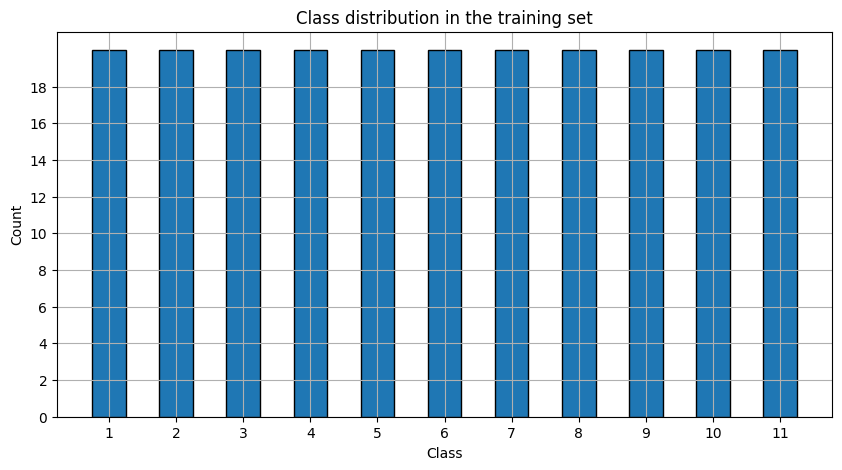

In [4]:
count = Counter(train_labels)

plt.figure(figsize = (10, 5))
plt.grid(True)
plt.bar(count.keys(), count.values(), width = 0.5, edgecolor = 'black')
plt.xlabel("Class")
plt.ylabel("Count")

plt.title("Class distribution in the training set")
plt.yticks([2*i for i in range(10)])
plt.xticks([i for i in count.keys()])
plt.show()

In [21]:
sub = train_ts[train_labels == 2]

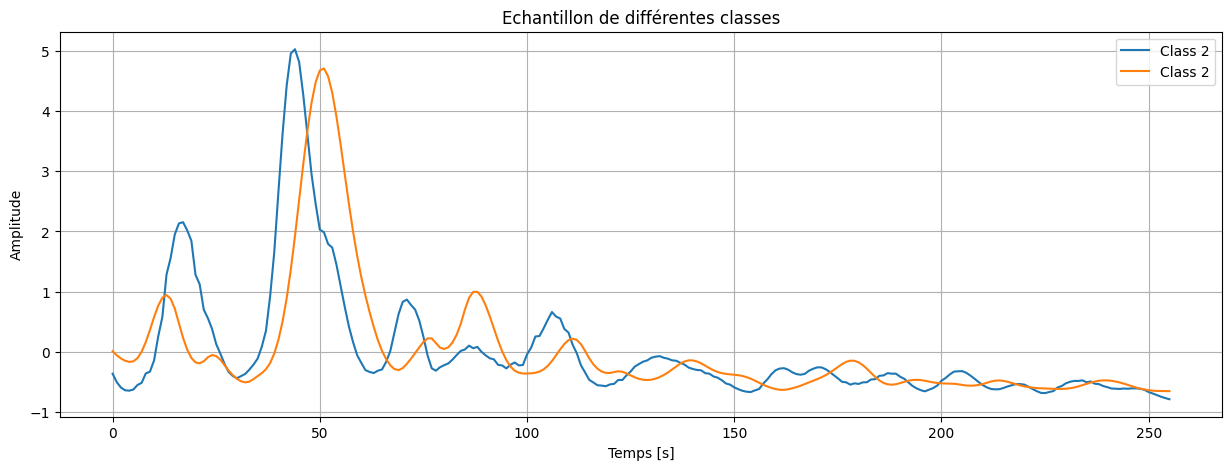

In [23]:
# Visualisons certains signaux
plt.figure(figsize = (15, 5))

plt.plot(sub[0], label = f"Class {train_labels[3]}")
plt.plot(sub[1], label = f"Class {train_labels[4]}")
#plt.plot(sub[2], label = f"Class {train_labels[5]}")
#plt.plot(sub[3], label = f"Class {train_labels[7]}")
#plt.plot(sub[4], label = f"Class {train_labels[5]}")
#plt.plot(sub[5], label = f"Class {train_labels[7]}")
plt.legend()
plt.xlabel('Temps [s]')
plt.ylabel('Amplitude')
plt.title('Echantillon de différentes classes')
plt.grid()
plt.show()

In [29]:
EXEC = False
if EXEC :
    def compute_dtw(i, j):
        return i, j, dtw.get_dtw_distance(train_ts[i], train_ts[j])

    train_set_size = len(train_labels)

    DTW_distance_matrix = np.zeros([train_set_size, train_set_size])

    results = Parallel(n_jobs=-1)(delayed(compute_dtw)(i, j) 
                                for i in tqdm(range(train_set_size), disable = False) 
                                for j in range(i, train_set_size))

    # Remplissage de la matrice à partir des résultats
    for i, j, dist in results:
        DTW_distance_matrix[i, j] = dist
        DTW_distance_matrix[j, i] = dist
else : 
    
    DTW_distance_matrix = np.load('train_dtw_InsectWingbeatSound.npy')

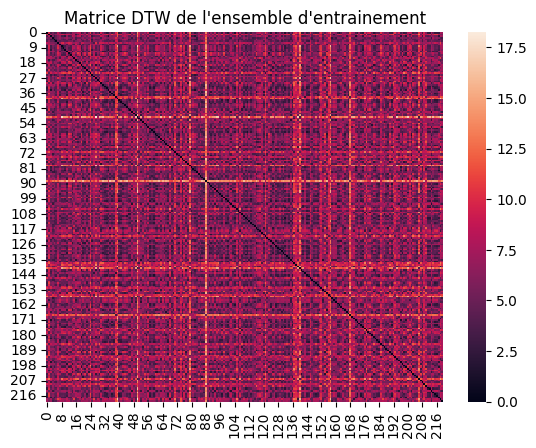

In [7]:
sns.heatmap(DTW_distance_matrix)
plt.title("Matrice DTW de l'ensemble d'entrainement")
plt.show()

In [8]:
# Récupération des indices de la classe cible
class_idx = np.where(train_labels == 10)[0]

# Récupération des séries temporelles de la classe cible
class_ts = train_ts[class_idx, :]

# Calcul de la "moyenne" de ces séries
mean_ts = dba.DBA(class_ts, class_idx, 10, DTW_distance_matrix, subset_size = 10)

In [61]:
classes = np.arange(1, 12)

centroids = np.zeros([11, 2, 256])

for id_class in tqdm(classes):
    # Récupération de la classe associé
    class_ts = train_ts[train_labels == id_class]
    class_idx = np.where(train_labels == id_class)
    
    class_dtw_mat = dtw.extract_sub_dtw_mat(DTW_distance_matrix, list(class_idx[0]))
    KM_Classifier = KMeans(nb_clusters = 2, max_iter = 10, eps = 1.5)
    KM_Classifier.fit(class_ts, class_dtw_mat)

    centroids[id_class-1] = KM_Classifier.centroids

  9%|▉         | 1/11 [01:11<11:59, 72.00s/it]

Convergence criterion satisfied before reaching 10 iterations


 18%|█▊        | 2/11 [04:55<24:11, 161.33s/it]

Convergence criterion satisfied before reaching 10 iterations


 27%|██▋       | 3/11 [06:10<16:15, 121.88s/it]

Convergence criterion satisfied before reaching 10 iterations


 36%|███▋      | 4/11 [07:01<10:57, 93.86s/it] 

Convergence criterion satisfied before reaching 10 iterations


 45%|████▌     | 5/11 [07:52<07:49, 78.22s/it]

Convergence criterion satisfied before reaching 10 iterations


 55%|█████▍    | 6/11 [09:07<06:26, 77.31s/it]

Convergence criterion satisfied before reaching 10 iterations


 64%|██████▎   | 7/11 [09:57<04:33, 68.30s/it]

Convergence criterion satisfied before reaching 10 iterations


 73%|███████▎  | 8/11 [11:11<03:30, 70.24s/it]

Convergence criterion satisfied before reaching 10 iterations


 82%|████████▏ | 9/11 [11:59<02:06, 63.29s/it]

Convergence criterion satisfied before reaching 10 iterations


 91%|█████████ | 10/11 [12:48<00:58, 58.75s/it]

Convergence criterion satisfied before reaching 10 iterations


100%|██████████| 11/11 [14:02<00:00, 76.61s/it]

Convergence criterion satisfied before reaching 10 iterations


In [96]:
ts = test_ts[10]
distances = []
nb_class = centroids.shape[0] 

for class_idx in range(nb_class) :
    # Récupérer des centroides d'une classe donnée
    class_centroids = centroids[class_idx]

    min_dtw_distance = min([dtw.get_dtw_distance(ts, centroid) for centroid in class_centroids])  
    distances.append(min_dtw_distance)

closest_class = np.argmin(distances) + 1

In [97]:
closest_class

4

In [98]:
test_labels[10]

4